In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import gc
import warnings
%matplotlib inline
sns.set_style('whitegrid')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train_transaction_path = 'train_transaction.csv'
train_identity_path = 'train_identity.csv'

try:
    train_transaction_df = pd.read_csv(train_transaction_path)
    train_identity_df = pd.read_csv(train_identity_path)

    print(f"train_transaction_df shape: {train_transaction_df.shape}")
    print(f"train_identity_df shape: {train_identity_df.shape}")

except FileNotFoundError as e:
    print(f"Error: {e}")

train_transaction_df shape: (590540, 394)
train_identity_df shape: (144233, 41)


In [3]:
transaction_cols = train_transaction_df.columns.tolist()
identity_cols = train_identity_df.columns.tolist()
print(transaction_cols)
print(identity_cols)

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

In [4]:
train_df = pd.merge(
    train_transaction_df,
    train_identity_df,
    on='TransactionID',
    how='left'
)

print(f"New merged train_df shape: {train_df.shape}")

New merged train_df shape: (590540, 434)


In [5]:
del train_transaction_df, train_identity_df
gc.collect()

4

In [6]:
def get_missing_value_percentage(dataframe):
    missing_percentage = (dataframe.isnull().sum() / len(dataframe)) * 100
    missing_df = pd.DataFrame({
        'column_name': dataframe.columns,
        'missing_percentage': missing_percentage
    })
    missing_df = missing_df.sort_values('missing_percentage', ascending=False).reset_index(drop=True)
    
    return missing_df
missing_values = get_missing_value_percentage(train_df)
print(missing_values.head(20))

   column_name  missing_percentage
0        id_24           99.196159
1        id_25           99.130965
2        id_07           99.127070
3        id_08           99.127070
4        id_21           99.126393
5        id_26           99.125715
6        id_27           99.124699
7        id_23           99.124699
8        id_22           99.124699
9        dist2           93.628374
10          D7           93.409930
11       id_18           92.360721
12         D13           89.509263
13         D14           89.469469
14         D12           89.041047
15       id_03           88.768923
16       id_04           88.768923
17          D6           87.606767
18       id_33           87.589494
19       id_10           87.312290


In [7]:
data_types = train_df.dtypes.value_counts()
print(data_types)

float64    399
object      31
int64        4
Name: count, dtype: int64


In [8]:
missing_value_threshold = 50.0
cols_to_drop = missing_values[missing_values['missing_percentage'] > missing_value_threshold]['column_name'].tolist()
train_df = train_df.drop(columns=cols_to_drop)

print(f"Dropped {len(cols_to_drop)} columns.")
print(f"New shape: {train_df.shape}")

Dropped 214 columns.
New shape: (590540, 220)


isFraud
0    96.500999
1     3.499001
Name: proportion, dtype: float64


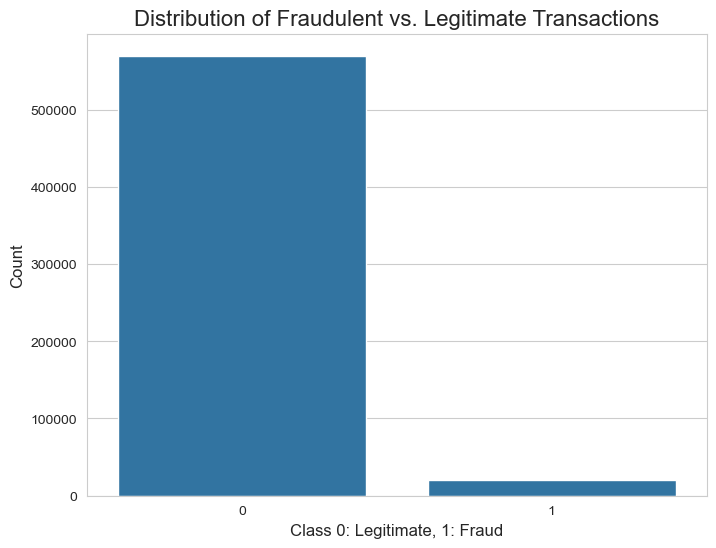

In [9]:
fraud_distribution = train_df['isFraud'].value_counts(normalize=True) * 100
print(fraud_distribution)


plt.figure(figsize=(8, 6))
sns.countplot(x='isFraud', data=train_df)
plt.title('Distribution of Fraudulent vs. Legitimate Transactions', fontsize=16)
plt.xlabel('Class 0: Legitimate, 1: Fraud', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [10]:
categorical_cols = [c for c in train_df.columns if train_df[c].dtype == 'object']
numerical_cols = [c for c in train_df.columns if train_df[c].dtype != 'object' and c not in ['isFraud', 'TransactionID']]

print(f"Found {len(categorical_cols)} categorical columns")
print(f"Found {len(numerical_cols)} numerical columns")

Found 9 categorical columns
Found 209 numerical columns


In [11]:
for col in numerical_cols:
    train_df[col] = train_df[col].fillna(train_df[col].median())
for col in categorical_cols:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

In [12]:
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])

total_missing = train_df.isnull().sum().sum()
print(f"Total remaining missing values: {total_missing}")

Total remaining missing values: 0


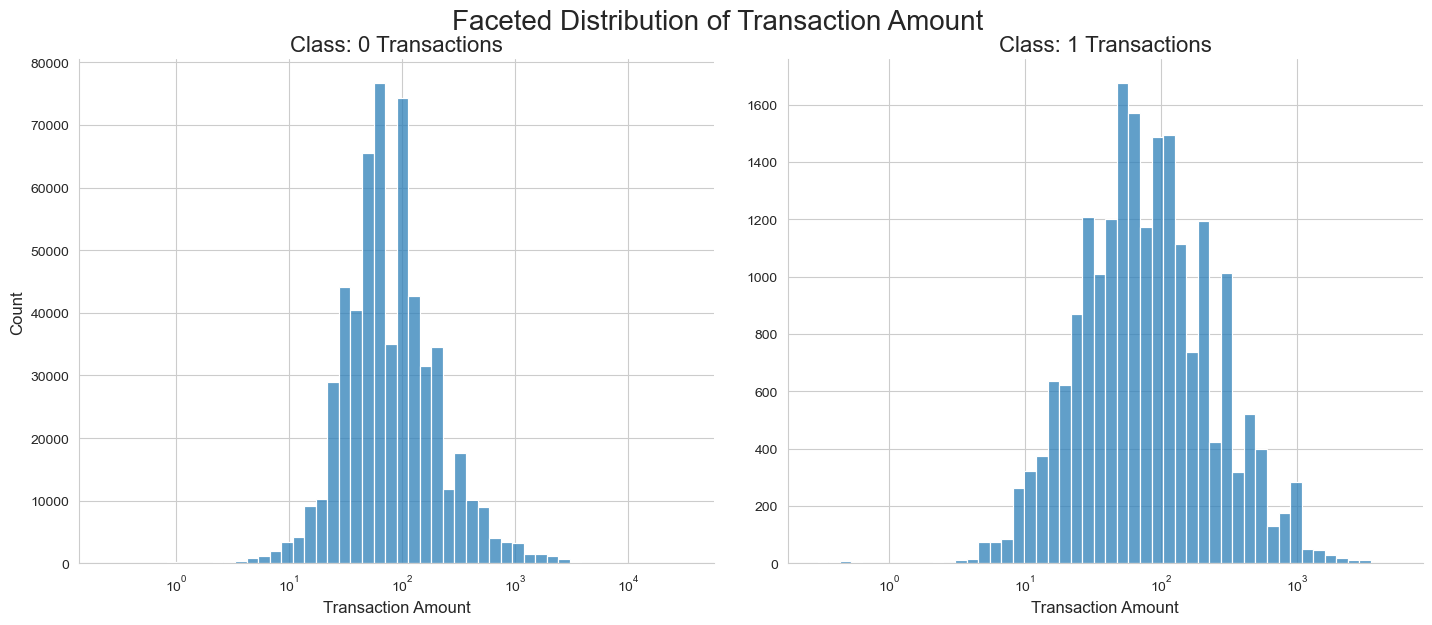

In [13]:
g = sns.FacetGrid(train_df, col="isFraud", height=6, aspect=1.2, sharex=False, sharey=False)
g.map(sns.histplot, "TransactionAmt", bins=50, color="#2c7fb8", log_scale=True)
g.set_titles("Class: {col_name} Transactions", size=16)
g.set_axis_labels("Transaction Amount", "Count", size=12)
g.fig.suptitle('Faceted Distribution of Transaction Amount', y=1.03, size=20)
plt.show()

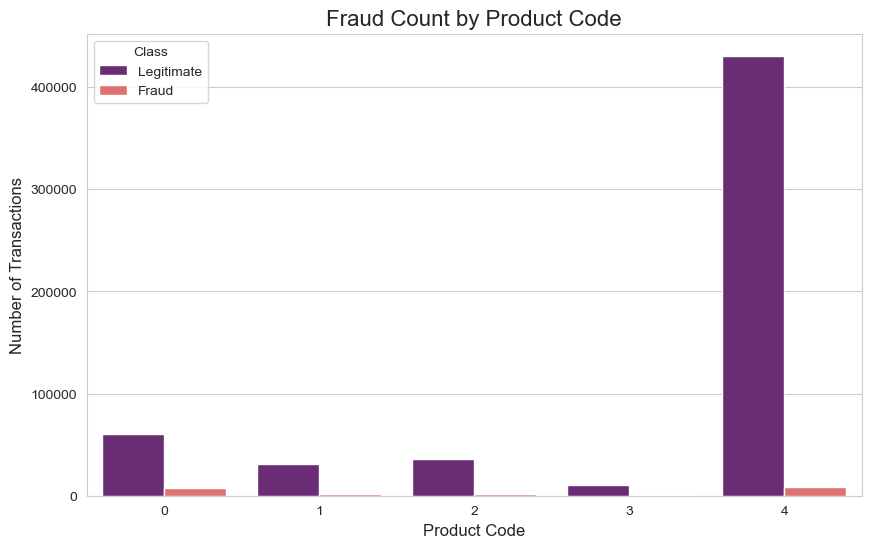

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=train_df,
    x='ProductCD',
    hue='isFraud',
    palette='magma'
)

plt.title('Fraud Count by Product Code', fontsize=16)
plt.xlabel('Product Code', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.legend(title='Class', labels=['Legitimate', 'Fraud'])
plt.show()

C:\Users\ncpr0\AppData\Local\Temp\ipykernel_27240\675856041.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['hour_of_day'] = (train_df['TransactionDT'] // 3600) % 24


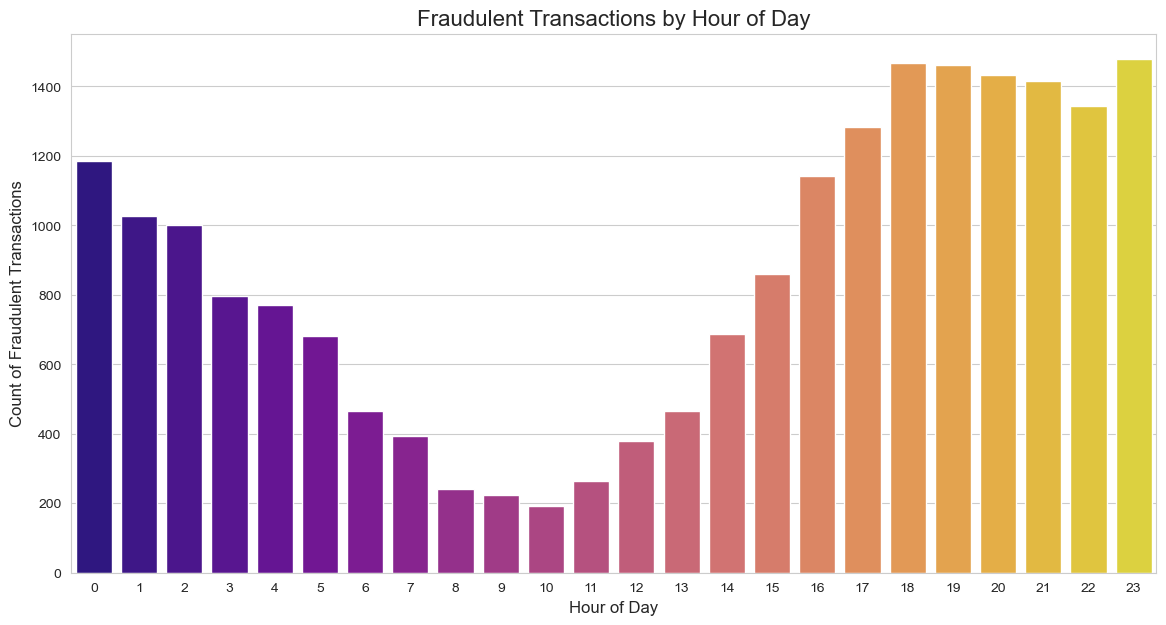

In [15]:
seconds_in_day = 86400 
train_df['hour_of_day'] = (train_df['TransactionDT'] // 3600) % 24
plt.figure(figsize=(14, 7))
sns.countplot(
    data=train_df[train_df['isFraud'] == 1],
    x='hour_of_day',
    palette='plasma'
)

plt.title('Fraudulent Transactions by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Count of Fraudulent Transactions', fontsize=12)
plt.show()

In [16]:
output_file = 'train_cleaned.parquet'
train_df.to_parquet(output_file, index=False)